### Sampling - Baseline : GRU

In [42]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random

import sys
from datetime import datetime

#### VM Model

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
import lightgbm
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from scipy.stats import kurtosis, skew
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler

In [44]:
# with former MRR X data
def get_orig_data(dataset):

    train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0).reset_index(drop=True)
    test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0).reset_index(drop=True)

    short_sampled_orig = train_orig.iloc[316*2:, :].reset_index(drop=True)
    former_mrr_sampled = train_orig.iloc[:-316*2, -1].rename('former_MRR').reset_index(drop=True)
    addmrr_sampled_orig = pd.concat([short_sampled_orig, former_mrr_sampled], axis=1)
    fmrr_scaler = MinMaxScaler().fit(addmrr_sampled_orig[['former_MRR']])
    addmrr_sampled_orig['former_MRR'] = fmrr_scaler.transform(addmrr_sampled_orig[['former_MRR']])

    short_unsampled_orig = train_orig.iloc[316*1:, :].reset_index(drop=True)
    former_mrr_unsampled = train_orig.iloc[:-316*1, -1].rename('former_MRR').reset_index(drop=True)
    addmrr_unsampled_orig = pd.concat([short_unsampled_orig, former_mrr_unsampled], axis=1)
    addmrr_unsampled_orig['former_MRR'] = fmrr_scaler.transform(addmrr_unsampled_orig[['former_MRR']])

    former_mrr_test = pd.concat([train_orig.iloc[-316*1:, -1], test_orig.iloc[:-316*1, -1]], ignore_index=True).rename("former_MRR").reset_index(drop=True)
    addmrr_test_orig = pd.concat([test_orig, former_mrr_test], axis=1)
    addmrr_test_orig['former_MRR'] = fmrr_scaler.transform(addmrr_test_orig[['former_MRR']])
    
    return addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig

def get_stats_data(data):
    orig_X = data.iloc[:, :-2].to_numpy()
    orig_X = orig_X.reshape(-1, 316, orig_X.shape[1])
    orig_y = data.iloc[:, -2].tolist()
    data_y = [orig_y[i] for i in range(0, len(orig_y), 316)]
    former_mrr = data.iloc[:, -1].tolist()
    former_mrr = [former_mrr[i] for i in range(0, len(former_mrr), 316)]
    
    # calculate statistics
    means = np.mean(orig_X, axis=1)
    stds = np.std(orig_X, axis=1)
    medians = np.median(orig_X, axis=1)
    mins = np.min(orig_X, axis=1)
    maxs = np.max(orig_X, axis=1)
    kurts = kurtosis(orig_X, axis=1)
    skews = skew(orig_X, axis=1)
    stats_X = np.hstack([means, stds, medians, mins, maxs, kurts, skews])
    stats_X = np.nan_to_num(stats_X, nan=0.0)

    # add MRR
    former_mrr = np.array(former_mrr).reshape(-1,1)
    data_X = np.concatenate((stats_X, former_mrr), axis=1)

    return data_X, data_y

def fit_XGB(X_train, y_train):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',  # 回歸問題
        'max_depth': 3,                    # 樹的最大深度
        'learning_rate': 0.01,              # 學習率
        'n_estimators': 200                # 樹的數量
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def fit_RF(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)
    return model

def fit_KNN(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def fit_MLP(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(128, 16), activation='relu', solver='adam', max_iter=2000, random_state=2)
    model.fit(X_train, y_train)
    return model

def get_Stats_pred(dataset, mode_type):  # model_type: 'XGB'/'RF'/'KNN'
    
    addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig = get_orig_data(dataset)
    # retain only sampled section
    sampled_train_orig = pd.concat([addmrr_sampled_orig.iloc[i:i+316] for i in range(0, len(addmrr_sampled_orig), 316*2)], ignore_index=True)
    unsampled_train_orig = pd.concat([addmrr_unsampled_orig.iloc[i:i+316] for i in range(316, len(addmrr_unsampled_orig), 316*2)], ignore_index=True)
    #test_orig = pd.concat([test_orig.iloc[i:i+316] for i in range(0, len(test_orig), 316*2)], ignore_index=True)

    all_test_orig = pd.concat([unsampled_train_orig, addmrr_test_orig], ignore_index=True)
    extend_test_orig = pd.concat([addmrr_unsampled_orig.iloc[-316*4:], addmrr_test_orig], ignore_index=True)

    y_pred = {}
    X_train, y_train = get_stats_data(sampled_train_orig)

    data_modes = {'unsampled':unsampled_train_orig, 'test':addmrr_test_orig, 'all':all_test_orig, 'extend':extend_test_orig}
    for mode, data in data_modes.items():
        match mode_type:
            case 'XGB':
                model = fit_XGB(X_train, y_train)
            case 'RF':
                model = fit_RF(X_train, y_train)
            case 'KNN':
                model = fit_KNN(X_train, y_train)
            case 'MLP':
                model = fit_MLP(X_train, y_train)

        X_test, y_test = get_stats_data(data)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)

        print('------------------------------------------------')
        print(mode)
        print(f"statistic-{mode_type} VM test loss", round(mse, 3))
        y_pred[mode] = model.predict(X_test)

    return y_pred

#### PHM Model

In [45]:
# check GPU situation
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
NVIDIA GeForce RTX 3090 Ti
11.8


In [46]:
# function to seed random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed_all(seed)

     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)

     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [47]:
# load the raw data
def get_data(dataset):
    data = pd.read_csv(f'./data/{dataset}_MRR.csv')
    mrr_data = data['MRR']
    mrr_train = mrr_data[:int(len(mrr_data) * 0.7)]
    mrr_test = mrr_data[int(len(mrr_data) * 0.7):] 

    return mrr_train, mrr_test

In [66]:
# transfer raw data to dataset class
class myDataset(Dataset):
    def __init__(self, data, data_orig, past_wafer, future_step, mode='train'):
        data = torch.tensor(data)
        data_orig = torch.tensor(data_orig.values)
        seqs = []
        tars = []
        future_step = future_step - 1
        rang = range(past_wafer, len(data) - future_step, 2) if mode == 'train' else range(past_wafer, len(data) - future_step)
        for i in rang:
            seq = data[i - past_wafer:i]
            tar = data_orig[i + future_step]
            seqs.append(seq)
            tars.append(tar)
        
        self.x = torch.unsqueeze(torch.stack(seqs), 2).contiguous()
        self.y = torch.stack(tars).contiguous()
        self.len = len(seqs)

    def __getitem__(self, idx):

        x = self.x[idx].double()
        y = self.y[idx].double()

        return x, y
    
    def __len__(self):
        return self.len

In [49]:
# GRU model setting
class GRUmodel(nn.Module):
    def __init__(self, input_dim, inter_dim, layer_num):
        super(GRUmodel, self).__init__()
        self.inter_dim = inter_dim
        self.layer_num = layer_num

        # define GRU layer
        self.gru = nn.GRU(input_dim, inter_dim, layer_num, batch_first=True)

        # define MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(inter_dim, 1),
            nn.ReLU())
        

    def forward(self, x):
        # initialize original memory
        h0 = torch.zeros(self.layer_num, x.size(0), self.inter_dim).double().to(x.device)

        # forward propagation，x size (batch_size, sequence_length, input_dim)
        out, _ = self.gru(x, h0)

        # retain the last memory
        out = self.mlp(out[:, -1, :])

        return out.squeeze(1)


In [50]:
# split train_dataloader and val_dataloader from train_dataset
def get_loaders(train_dataset, seed, batch_size, val_ratio=0.1):
    dataset_len = int(len(train_dataset))
    train_use_len = int(dataset_len * (1 - val_ratio))
    val_use_len = int(dataset_len * val_ratio)
    val_start_index = random.randrange(train_use_len)
    indices = torch.arange(dataset_len)

    train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
    train_subset = Subset(train_dataset, train_sub_indices)

    val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
    val_subset = Subset(train_dataset, val_sub_indices)

    train_dataloader = DataLoader(train_subset, batch_size,
                            shuffle=False)

    val_dataloader = DataLoader(val_subset, batch_size,
                            shuffle=False)

    return train_dataloader, val_dataloader

In [51]:
def test(model, test_dataloader, device):
    model.eval()

    test_pred_list = []
    test_ground_list = []
    loss_list = []

    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():

            model = model.double()
            out = model(x).to(device)
            loss = F.mse_loss(out, y, reduction='mean')
            
            test_pred_list.extend(out.detach().cpu().tolist())
            test_ground_list.extend(y.detach().cpu().tolist())
            
        loss_list.append(loss.detach().cpu().item())
    
    avg_loss = sum(loss_list)/len(loss_list)

    return avg_loss, [test_pred_list, test_ground_list] 

In [52]:
def train(model, train_dataloader, val_dataloader, optimizer, epoch, device, path):
    min_loss = 1e+8
    early_stop_win = 30

    for i_epoch in range(epoch):

        loss_list = []
        acu_loss = 0
        model.train()

        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            model = model.double()
            out = model(x).to(device)
            loss = F.mse_loss(out, y, reduction='mean')

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            acu_loss += loss.item()

        val_loss = 0

        # early stopping by validation
        if val_dataloader is not None:

            val_loss, val_result = test(model, val_dataloader, 'cuda')

            if val_loss < min_loss:
                torch.save(model.state_dict(), path)

                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            if acu_loss < min_loss:
                torch.save(model.state_dict(), path)
                min_loss = acu_loss

        # print each epoch
        print(
            'epoch ({} / {}) (Train_loss:{:.8f}, ACU_loss:{:.8f}, Val_loss:{:.8f})'
            .format(
                i_epoch + 1,
                epoch,
                acu_loss / len(train_dataloader),
                acu_loss,
                val_loss,
            ),
            flush=True)

In [54]:
# 合併VM資料
def combine_vm_data(train, test, vm_train, vm_test):
    train = train[2:].reset_index(drop=True)
    com_trian = [train[i] if i % 2 == 0 else vm_train[int(i / 2)] for i in range(len(train))]
    test = test.reset_index(drop=True)
    com_test = [test[i] if i % 2 == 0 else vm_test[i] for i in range(len(test))]

    return com_trian, com_test

A456

In [ ]:
# training setting
dataset = 'A456'
batch_size = 8
input_dim = 1
inter_dim = 64
layer_num = 1
past_wafer = 4
future_step = 1
val_ratio = 0.3
seed = 2

# set random seed
setup_seed(seed)

In [93]:
# get training and testing dataset
train_orig, test_orig = get_data(dataset)
# concat the first n wafer data from training set
test_extend = pd.concat((train_orig[-past_wafer:], test_orig))

vm_pred = get_Stats_pred(dataset,'RF')
vm_train = vm_pred['unsampled']
vm_test = vm_pred['extend']
com_train, com_test = combine_vm_data(train_orig, test_extend, vm_train, vm_test)

------------------------------------------------
unsampled
statistic-RF VM test loss 4.381
------------------------------------------------
test
statistic-RF VM test loss 12.192
------------------------------------------------
all
statistic-RF VM test loss 7.993
------------------------------------------------
extend
statistic-RF VM test loss 12.179


In [100]:
train_dataset = myDataset(com_train, train_orig, past_wafer, future_step)
test_dataset = myDataset(com_test, test_extend, past_wafer, future_step)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = GRUmodel(input_dim, inter_dim, layer_num).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:4736.97056979, ACU_loss:71054.55854691, Val_loss:5681.08114423)
epoch (2 / 2000) (Train_loss:4570.03348613, ACU_loss:68550.50229200, Val_loss:5486.99250867)
epoch (3 / 2000) (Train_loss:4368.50667065, ACU_loss:65527.60005970, Val_loss:5255.64622219)
epoch (4 / 2000) (Train_loss:4179.46985749, ACU_loss:62692.04786235, Val_loss:5061.76948043)
epoch (5 / 2000) (Train_loss:4021.21695303, ACU_loss:60318.25429548, Val_loss:4896.31617296)
epoch (6 / 2000) (Train_loss:3887.55501926, ACU_loss:58313.32528891, Val_loss:4755.23171936)
epoch (7 / 2000) (Train_loss:3759.73099891, ACU_loss:56395.96498372, Val_loss:4610.31035646)
epoch (8 / 2000) (Train_loss:3629.16373808, ACU_loss:54437.45607118, Val_loss:4465.08529309)
epoch (9 / 2000) (Train_loss:3509.38430377, ACU_loss:52640.76455650, Val_loss:4337.07715036)
epoch (10 / 2000) (Train_loss:3397.00991709, ACU_loss:50955.14875642, Val_loss:4209.90095067)
epoch (11 / 2000) (Train_loss:3271.38109326, ACU_loss:49070.71639888,

MSE :  12.161


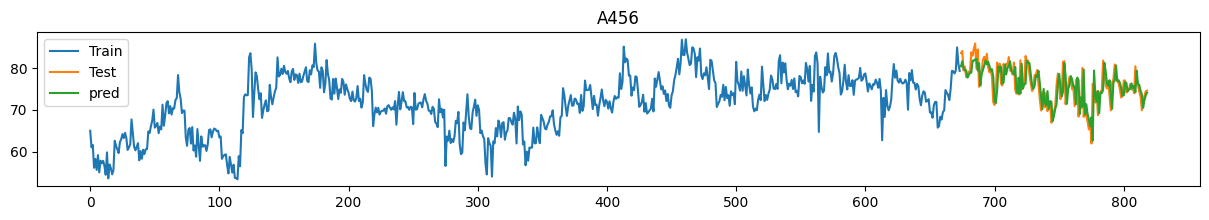

In [69]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', round(avg_loss, 3))

# plot the result
y_train = train_orig
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(y_train.shape[0]), y_train, label='Train')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_truth, label='Test')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()

B456

In [118]:
# training setting
dataset = 'B456'
batch_size = 64
input_dim = 1
inter_dim = 64
layer_num = 1
past_wafer = 4
future_step = 1
val_ratio = 0.3
seed = 2

# set random seed
setup_seed(seed)

In [103]:
# get training and testing dataset
train_orig, test_orig = get_data(dataset)
# concat the first n wafer data from training set
test_extend = pd.concat((train_orig[-past_wafer:], test_orig))

vm_pred = get_Stats_pred(dataset,'RF')
vm_train = vm_pred['unsampled']
vm_test = vm_pred['extend']
com_train, com_test = combine_vm_data(train_orig, test_extend, vm_train, vm_test)

------------------------------------------------
unsampled
statistic-RF VM test loss 5.976
------------------------------------------------
test
statistic-RF VM test loss 17.214
------------------------------------------------
all
statistic-RF VM test loss 11.18
------------------------------------------------
extend
statistic-RF VM test loss 17.186


In [119]:
train_dataset = myDataset(com_train, train_orig, past_wafer, future_step)
test_dataset = myDataset(com_test, test_extend, past_wafer, future_step)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# split training and validation dataset
train_dataloader, val_dataloader = get_loaders(train_dataset, seed, batch_size, val_ratio)

# establish the model
model = GRUmodel(input_dim, inter_dim, layer_num).to('cuda')
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# save path of the best model
now = datetime.now()
datestr = now.strftime('%m_%d-%H_%M_%S')
save_path = f'./save_path/{datestr}.pt'

# start training
train(model, train_dataloader, val_dataloader, optimizer, 2000, 'cuda', save_path)

epoch (1 / 2000) (Train_loss:5602.65185432, ACU_loss:22410.60741726, Val_loss:6832.39277413)
epoch (2 / 2000) (Train_loss:5546.49591949, ACU_loss:22185.98367797, Val_loss:6776.76415727)
epoch (3 / 2000) (Train_loss:5498.00022918, ACU_loss:21992.00091671, Val_loss:6729.17139326)
epoch (4 / 2000) (Train_loss:5454.76739576, ACU_loss:21819.06958305, Val_loss:6684.61507920)
epoch (5 / 2000) (Train_loss:5412.24339835, ACU_loss:21648.97359339, Val_loss:6637.79311966)
epoch (6 / 2000) (Train_loss:5366.19467688, ACU_loss:21464.77870752, Val_loss:6584.61950593)
epoch (7 / 2000) (Train_loss:5314.22164500, ACU_loss:21256.88657999, Val_loss:6524.01358918)
epoch (8 / 2000) (Train_loss:5256.73878059, ACU_loss:21026.95512235, Val_loss:6457.91209010)
epoch (9 / 2000) (Train_loss:5195.19494002, ACU_loss:20780.77976010, Val_loss:6387.80512457)
epoch (10 / 2000) (Train_loss:5132.76345492, ACU_loss:20531.05381969, Val_loss:6319.96490440)
epoch (11 / 2000) (Train_loss:5074.30771578, ACU_loss:20297.23086313,

MSE :  20.458


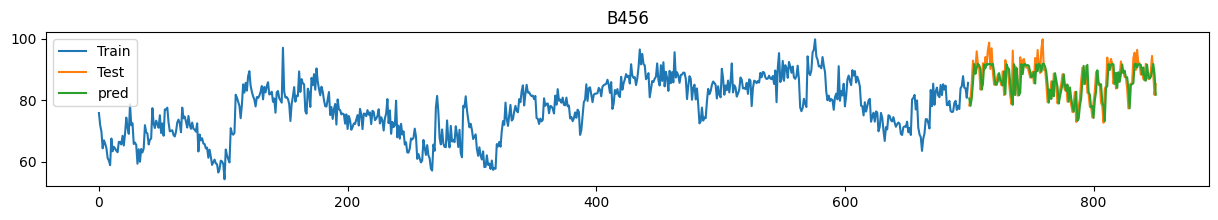

In [121]:
# load the best model for testing
model.load_state_dict(torch.load(save_path))
best_model = model.to('cuda')
avg_loss, test_list = test(best_model, test_dataloader, 'cuda')
print('MSE : ', round(avg_loss, 3))

# plot the result
y_train = train_orig
y_pred = test_list[0]
y_truth = test_list[1]

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(y_train.shape[0]), y_train, label='Train')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_truth, label='Test')
plt.plot(range(y_train.shape[0], y_train.shape[0] + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(loc='upper left')
plt.show()